# Static condensation and hybridization

In this notebook, we explore the more advanced capabilities of Firedrake which facilitate the global reduction of finite element systems. The procedure, known as element-wise "static condensation," is well-known within the FEM community. This approach requires the algebraic manipulation of locally assembled matrices and vectors. We will apply this within the context of hybridizing a mixed method.

As our running example, we consider the following saddle-point system: find $(\mathbf{u}, D) \in V \times U \subset H(\text{div}) \times L^2$ such that

$$
\begin{align}
    \color{#800020}{\int_\Omega \mathbf{w}\cdot\mathbf{u}\,\mathrm{d}x +
    \beta\int_\Omega \mathbf{w}\cdot f\mathbf{u}^\perp\,\mathrm{d}x}
    - \color{#2A52BE}{g\beta\int_\Omega D\nabla\cdot\mathbf{w}\,\mathrm{d}x} &= -R\lbrack \mathbf{w} \rbrack,
    \quad \forall \mathbf{w} \in V, \\
    \color{#2A52BE}{H\beta\int_\Omega \phi\nabla\cdot\mathbf{u}\,\mathrm{d}x}
    + \color{#CC5500}{\int_\Omega \phi D\,\mathrm{d}x} &= -R\lbrack \phi \rbrack,
    \quad \forall \phi \in U,
\end{align}
$$

where the residual co-vectors are defined as:

$$
\begin{align}
    R\lbrack \mathbf{w} \rbrack &= \int_\Omega \mathbf{w}\cdot\mathbf{u}^{0}\,\mathrm{d}x -
    \beta\int_\Omega \mathbf{w}\cdot f\mathbf{u}^{0\perp}\,\mathrm{d}x +
    g\beta\int_\Omega D^{0}\nabla\cdot\mathbf{w}\,\mathrm{d}x, \\
    R\lbrack \phi \rbrack &= \int_\Omega \phi D^{0}\,\mathrm{d}x -
    \beta\int_\Omega \phi\nabla\cdot\mathbf{u}^{0}\,\mathrm{d}x.
\end{align}
$$

Here, $\beta$, $g$, and $H$ are parameters. Within the context of fluid flow on a rotating sphere, $f$ is the Coriolis parameter. $\mathbf{u}^{0}$ and $D^0$ are previous states of the fields.

We require the numerical solution to the saddle-point system:

$$
    \mathcal{A}\mathbf{x} \equiv
    \begin{bmatrix}
        \color{#800020}{A} & -g\beta\color{#2A52BE}{B^T} \\
        H\beta\color{#2A52BE}{B} & \color{#CC5500}{C}
    \end{bmatrix}
    \begin{Bmatrix}
        U \\
        D
    \end{Bmatrix} =
    \begin{Bmatrix}
        -R\lbrack \mathbf{w} \rbrack \\
        -R\lbrack \phi \rbrack
    \end{Bmatrix} \equiv \mathbf{b}
$$

for the coefficent vectors $U$ and $D$. A challenge for systems of this type is finding a parameter-indepedent solver for which we have good convergence. First, let's set up an example.

## Example implementation

For our domain, let's use a spherical mesh with a radius equal to that of the Earth. We begin by importing Firedrake and defining some relevant constants.

In [1]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window
%matplotlib widget
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [2]:
from firedrake import *

R0 = 6371220.0                  # Radius
R = Constant(R0)
H = Constant(6000.0)            # Mean depth
Omega_f = Constant(1.e-4)       # Angular rotation rate
g = Constant(10)                # Acceleration due to gravity

Now let's create a mesh with quadrilateral elements. We will want to use Firedrake's `CubedSphereMesh`. As with all builtin meshes, we can find out what arguments we need to pass in:

In [3]:
help(CubedSphereMesh)

Help on cython_function_or_method in module firedrake.utility_meshes:

CubedSphereMesh(radius, refinement_level=0, degree=1, reorder=None, distribution_parameters=None, comm=<mpi4py.MPI.Intracomm object at 0x15f8ff330>, name='firedrake_default', distribution_name=None, permutation_name=None)
    Generate an cubed approximation to the surface of the
    sphere.

    :arg radius: The radius of the sphere to approximate.
    :kwarg refinement_level: optional number of refinements (0 is a cube).
    :kwarg degree: polynomial degree of coordinate space (e.g.,
           bilinear quads if degree=1).
    :kwarg reorder: (optional), should the mesh be reordered?
    :kwarg distribution_parameters: options controlling mesh
           distribution, see :func:`.Mesh` for details.
    :kwarg comm: Optional communicator to build the mesh on.
    :kwarg name: Optional name of the mesh.
    :kwarg distribution_name: the name of parallel distribution used
           when checkpointing; if `None`, the 

So now we need to specify the number of refinements (say 4). Let's also set the mesh `degree` to be cubic. With this choice of coordinate space, we can better resolve the actual curvature of the sphere using bendy quadrilateral elements:

In [4]:
mesh = CubedSphereMesh(radius=R0, refinement_level=4, degree=3)

And now we just initialize the global normals on this mesh:

In [5]:
x = SpatialCoordinate(mesh)
mesh.init_cell_orientations(x)

Let's take a look at the mesh:

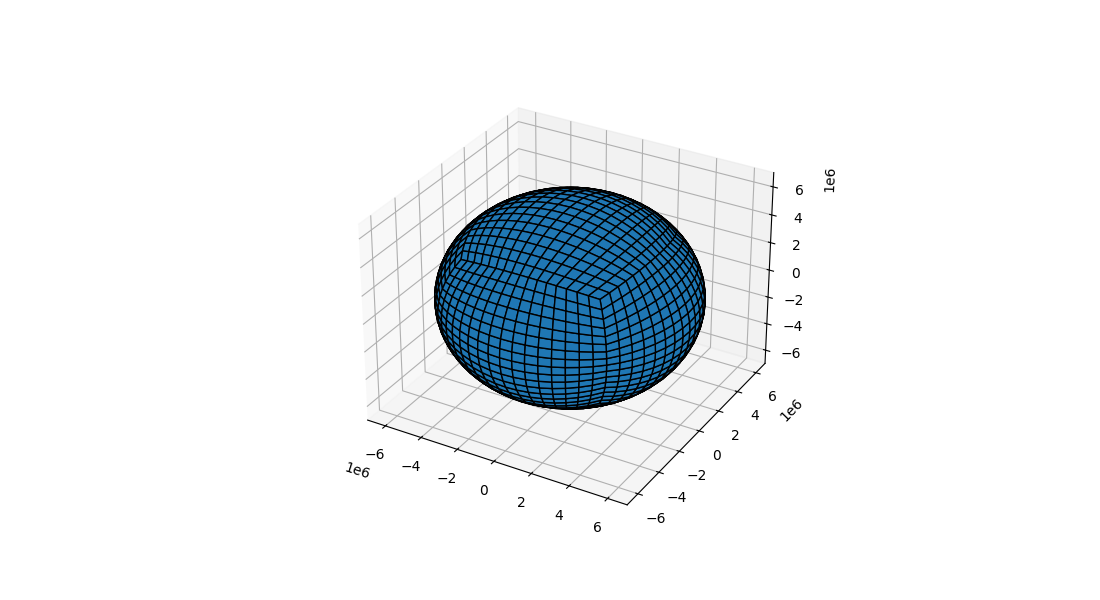

In [6]:
from firedrake.pyplot import triplot

fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
triplot(mesh, axes=axes);

Now let's define our discrete function spaces. We use a Raviart-Thomas (RT) mixed method on quadrilaterals, taking $V = RTCF_2$ and $U = DQ_1$:

<figure>
  <center><img src="image/rtcf2_dg1.png" alt="rtcf_dg" style="width: 400px;"/></center>
  <center><figcaption>$RTCF_2$ (left) and $DQ_1 (right)$.
      Source: <a href="http://femtable.org/">periodic table of finite elements</a>
      </figcaption></center>
</figure>

In [7]:
V = FunctionSpace(mesh, "RTCF", 2)
U = FunctionSpace(mesh, "DQ", 1)
W = V * U

And create an expression for the Coriolis term:

In [8]:
f = 2 * Omega_f * x[2] / R

For our initial profiles for $\mathbf{u}$ and $D$, we set them in steady rotating state:

$$
\begin{align}
    \mathbf{u}^0 &= \frac{u_{\text{max}}}{R}\left( -y, x, 0\right), \\
    D^0 &= H - \left(R\Omega_f u_{\text{max}} + \frac{u_{\text{max}}^2}{2}\right)\frac{z^2}{gR^2},
\end{align}
$$

where $u_{\text{max}} = 40.0 \text{m}\text{s}^{-1}$ and $\Omega_f$ is the planetary rotation rate. In Firedrake, we simply define the expressions in UFL and project/interpolate into the relevant finite element spaces:

In [9]:
u_max = Constant(40)
u_expr = as_vector([-u_max * x[1] / R, u_max * x[0] / R, 0.0])
D_expr = H -  (R * Omega_f * u_max + u_max**2 / 2.0) * (x[2]**2 / (g * R**2))
u0 = Function(V).project(u_expr)
D0 = Function(U).interpolate(D_expr)

We also need solution functions for $\mathbf{u}$ and $D$:

In [10]:
wh = Function(W, name="w_h")    # Fields in a mixed function

Now we set the coefficient parameter $\beta$ and define some test/trial functions:

In [11]:
beta = Constant(2000.0)
u, D = TrialFunctions(W)
w, phi = TestFunctions(W)

UFL has all the right objects to specify our problem. However, for the integral:
$$
\begin{equation*}
\int_\Omega \mathbf{w}\cdot f\mathbf{u}^\perp\,\mathrm{d}x,
\end{equation*}
$$
we need to be a bit careful. UFL does indeed have a `perp` operator, but it does not work for embedded manifolds. That is okay! Since UFL is all in Python, we can create our own `perp` via a Python function which returns a UFL expression:

In [12]:
perp = lambda u: cross(CellNormal(mesh), u)

Finally, we can define our finite element problem in residual form and create a `LinearVariationalProblem`. Here is the problem in residual form:

$$
\begin{align}
    0 = F(\mathbf{u}, D; \mathbf{w}, \phi) &=
    \color{#800020}{\int_\Omega \mathbf{w}\cdot\mathbf{u}\,\mathrm{d}x +
    \beta\int_\Omega \mathbf{w}\cdot f\mathbf{u}^\perp\,\mathrm{d}x} \\
    &- \color{#2A52BE}{g\beta\int_\Omega D\nabla\cdot\mathbf{w}\,\mathrm{d}x} \\
    &- \int_\Omega \mathbf{w}\cdot\mathbf{u}^{0}\,\mathrm{d}x
    + \beta\int_\Omega \mathbf{w}\cdot f\mathbf{u}^{0\perp}\,\mathrm{d}x \\
    &- g\beta\int_\Omega D^{0}\nabla\cdot\mathbf{w}\,\mathrm{d}x \\
    &+ \color{#CC5500}{\int_\Omega \phi D\,\mathrm{d}x} +
    \color{#2A52BE}{H\beta\int_\Omega \phi\nabla\cdot\mathbf{u}\,\mathrm{d}x} \\
    &- \int_\Omega \phi D^{0}\,\mathrm{d}x +
    \beta\int_\Omega \phi\nabla\cdot\mathbf{u}^{0}\,\mathrm{d}x,
\end{align}
$$

and in UFL:

In [13]:
uD_eqn = (inner(w, u) + beta*inner(w, f*perp(u))
          - g*beta*div(w)*D
          - inner(w, u0) + beta*inner(w, f*perp(u0))
          - g*beta*div(w)*D0
          + phi*D + H*beta*phi*div(u)
          - phi*D0 + H*beta*phi*div(u0))*dx
a = lhs(uD_eqn)
L = rhs(uD_eqn)

uD_problem = LinearVariationalProblem(a, L, wh, constant_jacobian=False)

## An approximate Schur-complement preconditioner

In exact arithmetic, the inverse of the Schur-complement factorization of $\mathcal{A}$ is:

$$
   \mathcal{A}^{-1} =
   \begin{bmatrix}
       I & g\beta \color{#800020}{A^{-1}}\color{#2A52BE}{B^T} \\
       0 & I
   \end{bmatrix}
   \begin{bmatrix}
       \color{#800020}{A^{-1}} & 0 \\
       0 & \color{#CC5500}{S}^{-1}
   \end{bmatrix}
   \begin{bmatrix}
       I & 0 \\
       -H\beta \color{#2A52BE}{B}\color{#800020}{A^{-1}} & I
   \end{bmatrix},
$$
where $\color{#CC5500}{S}$ is the Schur-complement:

$$
\begin{equation}
    \color{#CC5500}{S} = \color{#CC5500}{C} + gH\beta^2\color{#2A52BE}{B}\color{#800020}{A^{-1}}\color{#2A52BE}{B^T}.
\end{equation}
$$

Problem: $\color{#800020}{A^{-1}}$ is _dense_! Instead, let's construct a sparse approximation by using the diagonal of $\color{#800020}{A}$ to form:

$$
\begin{equation}
    \color{#CC5500}{\tilde{S}} = \color{#CC5500}{C} + gH\beta^2\color{#2A52BE}{B}\text{Diag}(\color{#800020}{A})^{-1}\color{#2A52BE}{B^T}.
\end{equation}
$$

Here, we use a block-preconditioner (centered around a full factorization) and approximately invert both $\color{#800020}{A}$ and $\color{#CC5500}{\tilde{S}}$:

In [14]:
solver_parameters = {'ksp_type': 'gmres',
                     'ksp_rtol': 1.0e-7,
                     'ksp_max_it': 1500,
                     'pc_type': 'fieldsplit',
                     'pc_fieldsplit': {'type': 'schur',
                                       'schur_fact_type': 'full',
                                       'schur_precondition': 'selfp'},
                     'fieldsplit_0': {'ksp_type': 'preonly',
                                      'pc_type': 'bjacobi',
                                      'sub_pc_type': 'ilu'},
                     'fieldsplit_1': {'ksp_type': 'preonly',
                                      'pc_type': 'gamg',
                                      'mg_levels': {'ksp_type': 'chebyshev',
                                                    'ksp_max_it': 5,
                                                    'pc_type': 'bjacobi',
                                                    'sub_pc_type': 'ilu'}}}
uD_solver_gmres = LinearVariationalSolver(uD_problem,
                                          solver_parameters=solver_parameters)

Now we just call solve, store our results, and take a look at the reduction in the residual:

In [15]:
wh.assign(0.0)
uD_solver_gmres.solve()
r = assemble(action(a, wh) - L)
b = assemble(L)
print("reduction in residual: %s" % (r.dat.norm / b.dat.norm))

reduction in residual: 1.4316859543564344e-08


### Solver convergence

Although the code we wrote above works fine, let's take a closer look by inspecting solver.

In [16]:
def gmres_solver_conv(solver):
    from firedrake.solving_utils import KSPReasons

    print("gmres iterations = {}, converged reason = {}".format(
           solver.snes.ksp.getIterationNumber(), 
           KSPReasons[solver.snes.ksp.getConvergedReason()]))

gmres_solver_conv(uD_solver_gmres)

gmres iterations = 4, converged reason = CONVERGED_RTOL


Okay. But what happens if we change the parameters a bit? For example, increasing $\beta$:

In [17]:
beta.assign(4000.0)
wh.assign(0.0)        # re-initialize solution vector
uD_solver_gmres.solve()
gmres_solver_conv(uD_solver_gmres)

gmres iterations = 5, converged reason = CONVERGED_RTOL


In [18]:
beta.assign(8000.0)
wh.assign(0.0)
uD_solver_gmres.solve()
gmres_solver_conv(uD_solver_gmres)

gmres iterations = 8, converged reason = CONVERGED_RTOL


In [19]:
beta.assign(16000.0)
wh.assign(0.0)
uD_solver_gmres.solve()
gmres_solver_conv(uD_solver_gmres)

gmres iterations = 20, converged reason = CONVERGED_RTOL


In [20]:
beta.assign(32000.0)
wh.assign(0.0)
uD_solver_gmres.solve()
gmres_solver_conv(uD_solver_gmres)

gmres iterations = 53, converged reason = CONVERGED_RTOL


In [21]:
beta.assign(64000.0)
wh.assign(0.0)
uD_solver_gmres.solve()
gmres_solver_conv(uD_solver_gmres)

gmres iterations = 554, converged reason = CONVERGED_RTOL


Yikes. Can we do better?

## The hybridized mixed method

Hybridizing the mixed formulation is an alternative approach which avoids building a global dense operator. We seek approximations $\hat{\mathbf{u}}, D, \lambda \in \widehat{V} \times U \times T$, where $\widehat{V}$ is a _discontinuous_ version of $V$ and $T$ is the _trace_ of $V$.

$V = RTCF_2$ is continuous in the sense that nodes on the facets shared between cells are topologically identical. The result of rendering $V$ discontinuous removes this association:

<ul class="list-unstyled list-inline text-center">
  <li>
    <img src='image/w2.png' alt='w2' style="width: 275px;"/>
    <figcaption>$V$: continuous between facets.</figcaption>
  </li>
    &#160; &#160; &#160; &#160; &#160; &#160; &#160; &#160;
  <li>
    <img src='image/w2b.png' alt='w2b' style="width: 320px;"/>
    <figcaption>$\widehat{V}$: no continuity across cell facets.</figcaption>
  </li>
</ul>

The trace of $V$ is a scalar-valued function space defined only on the mesh skeleton, $\mathcal{E}$. It is constructed such that function in $T$ belong to the _same_ polynomial space as $\mathbf{w}\cdot\mathbf{n}$, $\mathbf{w} \in V$:

<figure>
    <center><img src='image/w2t.png' alt='w2t' style="width: 250px;"/></center>
    <center><figcaption>The space of traces, $T$. Functions in this space are discontinuous across vertices.</figcaption></center>
</figure>

The approximations $\hat{\mathbf{u}}, D, \lambda$ satisfy the following variational problem:

$$
\begin{align}
    \color{#800020}{\int_\Omega \hat{\mathbf{w}}\cdot\hat{\mathbf{u}}\,\mathrm{d}x +
    \beta\int_\Omega \hat{\mathbf{w}}\cdot f\hat{\mathbf{u}}^\perp\,\mathrm{d}x}
    - \color{#2A52BE}{g\beta\int_\Omega D\nabla\cdot\hat{\mathbf{w}}\,\mathrm{d}x} +
    \color{#50404D}{\sum_{K \in \Omega} \int_{\partial K} \lambda \hat{\mathbf{w}}\cdot\mathbf{n}\,\mathrm{d}s}
    &= -R\lbrack \hat{\mathbf{u}} \rbrack,
    \quad \forall \hat{\mathbf{w}} \in \widehat{V}, \\
    \color{#CC5500}{\int_\Omega \phi D\,\mathrm{d}x} +
    \color{#2A52BE}{H\beta\int_\Omega \phi\nabla\cdot\hat{\mathbf{u}}\,\mathrm{d}x} &= -R\lbrack \phi \rbrack,
    \quad \forall \phi \in U, \\
    \color{#50404D}{\sum_{K \in \Omega} \int_{\partial K} \gamma \hat{\mathbf{u}}\cdot\mathbf{n}\,\mathrm{d}s}
    &= 0, \quad\quad\quad \forall \gamma \in T.
\end{align}
$$

This is the "hybridized" mixed method, resulting in an augmented system with an additional unknown $\lambda$. This system is solving the same PDE.

### The discrete hybridized system

The resulting discrete system is:

$$
\begin{bmatrix}
    \color{#800020}{\hat{A}} & -g\beta\color{#2A52BE}{B^T} & \color{#50404D}{E^T} \\
    H\beta\color{#2A52BE}{B} & \color{#CC5500}{C} & 0 \\
    \color{#50404D}{E} & 0 & 0
\end{bmatrix}
\begin{Bmatrix}
    \hat{U} \\
    D \\
    \Lambda
\end{Bmatrix} =
\begin{Bmatrix}
    -R^n\lbrack \hat{\mathbf{w}} \rbrack \\
    -R^n\lbrack \phi \rbrack \\
    0
\end{Bmatrix}.
$$

Upon initial inspection, it may appear that hybridizing the mixed problem is counter-productive. However, since $\hat{U}$ and $D$ coupled within the cell interiors only, both can be **eliminated cell-wise** via static condensation!

<ul class="list-unstyled list-inline text-center">
  <li>
    <img src='image/global_mixed_sparsity.png' alt='sparsemat_mixed' style="width: 275px;"/>
    <figcaption>Sparsity pattern for the original mixed system.</figcaption>
  </li>
    &#160; &#160; &#160; &#160; &#160; &#160; &#160; &#160;
  <li>
    <img src='image/global_hybridized_sparsity.png' alt='sparsemat_mixed' style="width: 275px;"/>
    <figcaption>Sparsity pattern for the hybridizable system.</figcaption>
  </li>
</ul>

A reduced problem for $\Lambda$ can be formed:

$$
\begin{bmatrix}
    \color{#50404D}{E} & 0
\end{bmatrix}
\begin{bmatrix}
    \color{#800020}{\hat{A}} & -g\beta\color{#2A52BE}{B^T}\\
    H\beta\color{#2A52BE}{B} & \color{#CC5500}{C}
\end{bmatrix}^{-1}
\begin{bmatrix}
    \color{#50404D}{E^T} \\
    0
\end{bmatrix}
\Lambda =
\begin{bmatrix}
    \color{#50404D}{E} & 0
\end{bmatrix}
\begin{bmatrix}
    \color{#800020}{\hat{A}} & -g\beta\color{#2A52BE}{B^T}\\
    H\beta\color{#2A52BE}{B} & \color{#CC5500}{C}
\end{bmatrix}^{-1}
\begin{Bmatrix}
    -R^n\lbrack \hat{\mathbf{w}} \rbrack \\
    -R^n\lbrack \phi \rbrack
\end{Bmatrix}.
$$

There are a number of advantages to inverting the $\Lambda$ system over the original mixed problem.
* The full hybridized system is **never** explicitly assembled;

* The block operator:
$$
\begin{bmatrix}
    \color{#800020}{\hat{A}} & -g\beta\color{#2A52BE}{B^T}\\
    H\beta\color{#2A52BE}{B} & \color{#CC5500}{C}
\end{bmatrix}
$$
can be inverted cell-wise.

* Once $\Lambda$ is determined, $\hat{U}$ and $D$ can be **recovered cell-wise** by inverting the local systems:
$$
\begin{Bmatrix}
    \hat{U} \\
    D
\end{Bmatrix}
=
\begin{bmatrix}
    \color{#800020}{\hat{A}} & -g\beta\color{#2A52BE}{B^T}\\
    H\beta\color{#2A52BE}{B} & \color{#CC5500}{C}
\end{bmatrix}^{-1}
\left(
\begin{Bmatrix}
    -R^n\lbrack \hat{\mathbf{w}} \rbrack \\
    -R^n\lbrack \phi \rbrack
\end{Bmatrix}
-
\begin{bmatrix}
    \color{#50404D}{E^T}\\
    0
\end{bmatrix}
\Lambda\right).
$$

People are often dissuaded from hybridized finite element solvers for their tedious implementation stages. However, Firedrake possesses an abstraction layer for automatically generating element-local dense linear algebra kernels (Slate).
In Firedrake, you can write out the dense linear algebra expressions directly:

In [22]:
Vhat = FunctionSpace(mesh, BrokenElement(V.ufl_element()))
Uhat = FunctionSpace(mesh, U.ufl_element())
T = FunctionSpace(mesh, FiniteElement("HDiv Trace", mesh.ufl_cell(), 1))
Whybrid = Vhat * Uhat * T

n = FacetNormal(mesh)
uhat, Dhat, lambdar = TrialFunctions(Whybrid)
what, phihat, gammar = TestFunctions(Whybrid)

# bilinear form (hybrid-mixed system)
a_hybrid = ((inner(what, uhat) + beta*inner(what, f*perp(uhat))
            - g*beta*div(what)*Dhat
            + phihat*Dhat + H*beta*phihat*div(uhat))*dx
            + jump(what, n=n)*lambdar('+')*dS
            + jump(uhat, n=n)*gammar('+')*dS)

# Slate expression for element-wise static condensation
AA = Tensor(a_hybrid)
A = AA.blocks
S = A[2, 0:1] * A[0:1, 0:1].inv * A[0:1, 2]
print(S)

M_1[((2,), (0,))]_0 * (PartialPivLU(M_1[((0,), (0,))]_3)_2).inv * M_1[((0,), (2,))]_4


## Firedrake's hybridization interface

Using Firedrake's symbolic reasoning capability, we can automate the hybridization and static condensation operations using the Python-based preconditioner: `HybridizationPC`. It can be configured through usual PETSc options:

In [23]:
hybrid_parameters = {'ksp_type': 'preonly',
                     'mat_type': 'matfree',
                     'pc_type': 'python',
                     'pc_python_type': 'firedrake.HybridizationPC',
                     # Solver for the trace system
                     'hybridization': {'ksp_type': 'gmres',
                                       'pc_type': 'gamg',
                                       'pc_gamg_sym_graph': True,
                                       'ksp_rtol': 1e-7,
                                       'mg_levels': {'ksp_type': 'richardson',
                                                     'ksp_max_it': 5,
                                                     'pc_type': 'bjacobi',
                                                     'sub_pc_type': 'ilu'}}}

Now one can run the simulation just as before:

In [24]:
beta.assign(2000.0)      # set beta back to initial value
wh.assign(0.0)
uD_solver_hybrid = LinearVariationalSolver(uD_problem,
                                           solver_parameters=hybrid_parameters)
uD_solver_hybrid.solve()
r = assemble(action(a, wh) - L)
b = assemble(L)
print("reduction in residual: %s" % (r.dat.norm / b.dat.norm))

reduction in residual: 1.7694303099308495e-08


Great! Now how about a closer look at the solver.

### Solver convergence for the hybridized system

Let's stress out the hybridization solver a bit. As before, we write a convenience function for viewing solver convergence:

In [25]:
def hybrid_solver_conv(solver):
    from firedrake.solving_utils import KSPReasons

    # get the ksp associated with the trace system
    trace_ksp = solver.snes.ksp.getPC().getPythonContext().trace_ksp

    print("gmres iterations (trace sys) = {}, converged reason = {}".format(
          trace_ksp.getIterationNumber(), 
          KSPReasons[trace_ksp.getConvergedReason()]))

Just as we previously did with our approximate Schur-complement preconditioner, let's go ahead and start a sequence $\beta$-parametrized runs:

In [26]:
beta.assign(4000.0)
wh.assign(0.0)
uD_solver_hybrid.solve()
hybrid_solver_conv(uD_solver_hybrid)

gmres iterations (trace sys) = 4, converged reason = CONVERGED_RTOL


In [27]:
beta.assign(8000.0)
wh.assign(0.0)
uD_solver_hybrid.solve()
hybrid_solver_conv(uD_solver_hybrid)

gmres iterations (trace sys) = 6, converged reason = CONVERGED_RTOL


In [28]:
beta.assign(16000.0)
wh.assign(0.0)
uD_solver_hybrid.solve()
hybrid_solver_conv(uD_solver_hybrid)

gmres iterations (trace sys) = 8, converged reason = CONVERGED_RTOL


In [29]:
beta.assign(32000.0)
wh.assign(0.0)
uD_solver_hybrid.solve()
hybrid_solver_conv(uD_solver_hybrid)

gmres iterations (trace sys) = 16, converged reason = CONVERGED_RTOL


In [30]:
beta.assign(64000.0)
wh.assign(0.0)
uD_solver_hybrid.solve()
hybrid_solver_conv(uD_solver_hybrid)

gmres iterations (trace sys) = 39, converged reason = CONVERGED_RTOL


### Solver time comparison

Let's set up a problem and solve using preconditioned GMRES and with hybridization. Taking a modest value for $\beta$, we can use builtin notebook magic to time the execution of the solve:

In [31]:
beta.assign(32000.0);

Now let's time it:

In [32]:
%%timeit
wh.assign(0.0)
uD_solver_gmres.solve()

173 ms ± 405 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


And now for hybridization:

In [33]:
%%timeit
wh.assign(0.0)
uD_solver_hybrid.solve()

98.9 ms ± 274 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
